## Quantum circuit evolutionary topology applied on set partitioning problem



In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# here you need to put your folder path for functions and Instances_Benchmark
sys.path.append(r'')
file_folder = ''

In [2]:
from _utility import *

# read the instance file
w, c, A = read_instance(file_folder + "6.1.txt")

# biulding the Hamiltonian
parameters = (w, c, A)
H_op = build_hamiltonian(parameters)

# solving using Gurobi
solution = sp_gurobi(w, A)
ref_value = sp_objective(w, solution)

print("Solution:", solution)
print("ref_value:", ref_value)
print("Hamiltonian:", H_op)

Solution: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
ref_value: 102.0
Hamiltonian: SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'IIIIII', 'ZIZIII', 'ZIIZII', 'ZIIIZI', 'ZIIIIZ', 'IZZIII', 'IZIZII', 'IZIIZI', 'IZIIIZ', 'ZIZIII', 'IZZIII', 'IIZZII', 'IIZIZI', 'IIZIIZ', 'ZIIZII', 'IZIZII', 'IIZZII', 'IIIZZI', 'IIIZIZ', 'ZIIIZI', 'IZIIZI', 'IIZIZI', 'IIIZZI', 'IIIIZZ', 'ZIIIIZ', 'IZIIIZ', 'IIZIIZ', 'IIIZIZ', 'IIIIZZ'],
              coeffs=[ -850.5 +0.j, -1396.5 +0.j, -1396.5 +0.j, -1374.  +0.j, -1750.5 +0.j,
 -1192.5 +0.j,  5124.  +0.j,   228.75+0.j,   228.75+0.j,   183.  +0.j,
   320.25+0.j,   320.25+0.j,   320.25+0.j,   366.  +0.j,   228.75+0.j,
   228.75+0.j,   320.25+0.j,   183.  +0.j,   228.75+0.j,   274.5 +0.j,
   228.75+0.j,   320.25+0.j,   183.  +0.j,   411.75+0.j,    91.5 +0.j,
   183.  +0.j,   366.  +0.j,   228.75+0.j,   411.75+0.j,   228.75+0.j,
   320.25+0.j,   228.75+0.j,   274.5 +0.j,    91.5 +0.j,   228.75+0.j])


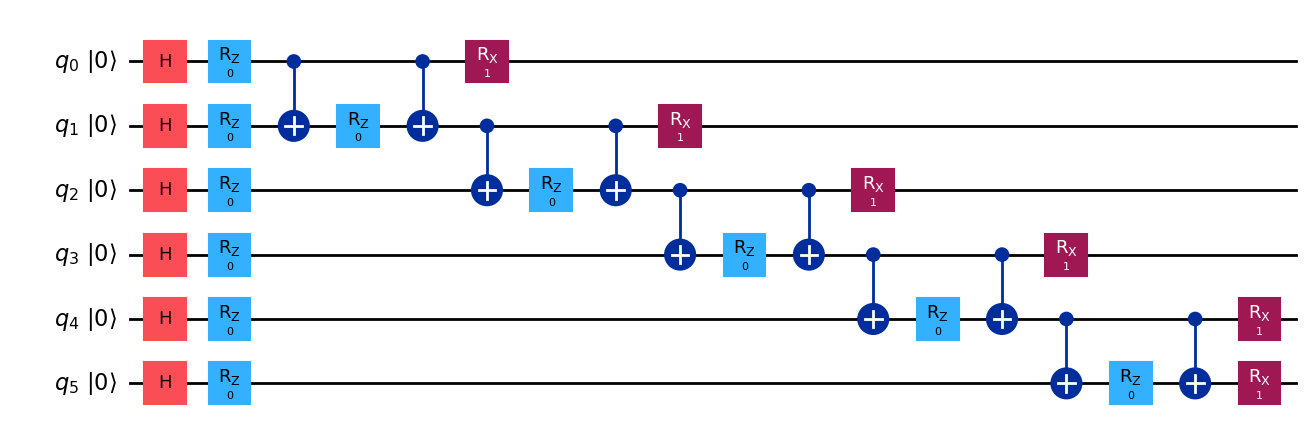

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

# Define the number of qubits and the number of layers
def ansatz_adiabatic(n_qubits):
    
    p = 1  # Number of layers

    # Parameters for a QAOA layer
    gamma = 0
    beta = 0.5

    # Manually constructing a QAOA layer for `p=1`
    qaoa_layer = QuantumCircuit(n_qubits)

    # Applying a rotation around Z for each qubit (Problem Hamiltonian)
    for qubit in range(n_qubits):
        qaoa_layer.h(qubit)
        qaoa_layer.rz(2 * gamma, qubit)

    # Applying CNOTs between adjacent qubits for the entanglement term
    for qubit in range(n_qubits - 1):
        qaoa_layer.cx(qubit, qubit + 1)
        qaoa_layer.rz(2 * gamma, qubit + 1)
        qaoa_layer.cx(qubit, qubit + 1)

    # Applying a rotation around X for each qubit (Mixer Hamiltonian)
    for qubit in range(n_qubits):
        qaoa_layer.rx(2 * beta, qubit)
    
    return qaoa_layer

# Displaying the layer
apcd_ansatz = ansatz_adiabatic(H_op.num_qubits)
apcd_ansatz.draw(initial_state=True, output="mpl", fold=-1)


In [4]:
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel, depolarizing_error


seed = 50
## for a noise-free test use this part
noiseless_estimator = Estimator(options={"seed":seed, "shots":1024})

## for a noise model test use this one
noise_model = NoiseModel()
coupling_map = [(i, i+1) for i in range(H_op.num_qubits - 1)]

# setting error to the gate 'cy'
error = depolarizing_error(0.01, 2)
noise_model.add_quantum_error(error, ['cy'], [0, 5])
basis_gates = noise_model.basis_gates

noisy_estimator = AerEstimator(
                    backend_options={
                        "coupling_map": coupling_map,
                        "noise_model": noise_model,
                        "basis_gates":basis_gates
                    },
                    run_options={"seed": seed, "shots": 1024},
                    transpile_options={"seed_transpiler": seed},
                    )

In [5]:
import qce

## for the AF-QCE config, you need to go in the qce.py and uncomment the line of single_gates and remove the apcd_ansatz term in the qce.minimize() below
## for the APCD-QCE config, you don't need to modify anything

print("-"*39)
print(f'Instance for {H_op.num_qubits}-qubits  Ref value: {ref_value}')
print("-"*39)

# initialize a dictionary to store results for each run
results_dict = {}

runs = 1
for run in range(runs):
    
    values, circuits = qce.minimize(estimator=noiseless_estimator, hamiltonian=H_op, cd_qaoa=apcd_ansatz, generations=10_000, population=4, ref_value=ref_value, restart = False, plot= False, tol=1e-1)

    # store the result and min_value in the dictionary
    results_dict[run] = {
        "values": values,
        "min_value": values[-1],
        "final_circuit": circuits[-1]
    }

# cxtract all min_values for easier processing
min_values = [results_dict[i]["min_value"] for i in range(runs)]

# calculate the median of the minimum values and the approx ration
median_min_value = np.median(min_values)
ratio =  ref_value / median_min_value 

index_best_run = min_values.index(min(min_values))

# Results
print("Minimum values for each run:", min_values)
print(f"Median of the minimum values: {median_min_value:.2f}")
print(f"Approximation ration: {ratio:.2f}\n")




---------------------------------------
Instance for 6-qubits  Ref value: 102.0
---------------------------------------
Minimum values for each run: [102.07431180777353]
Median of the minimum values: 102.07
Approximation ration: 1.00



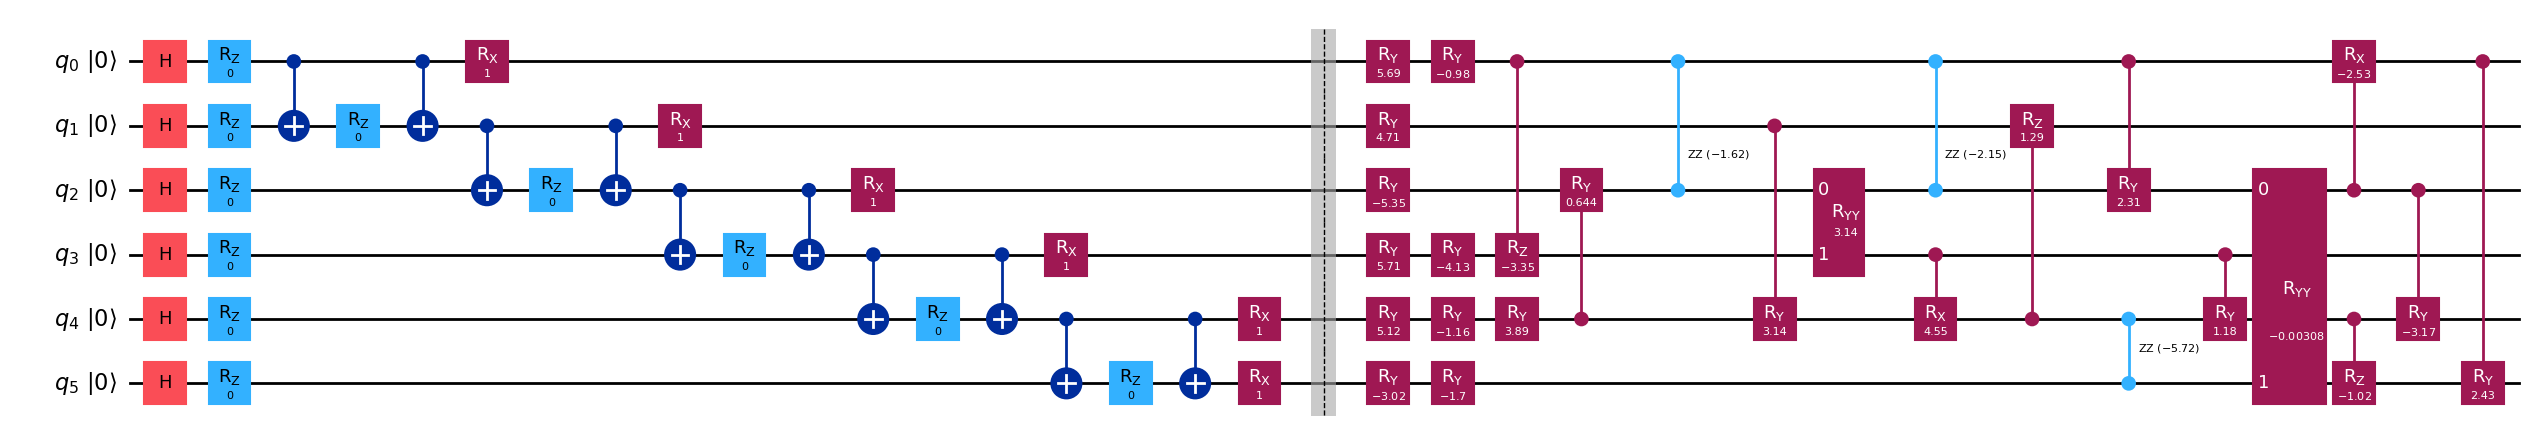

In [6]:
best_circuit = results_dict[index_best_run]['final_circuit']

## for the AF-QCE 
# ansatz = circuits[-1]

## for the APDC-QCE run the code below,
apcd_ansatz = ansatz_adiabatic(H_op.num_qubits)
apcd_ansatz.barrier()
ansatz = apcd_ansatz.compose(circuits[-1])

ansatz.draw(initial_state=True, output="mpl", fold=-1)

Gurobi Optimal Solution: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
VQE Solution: 110000


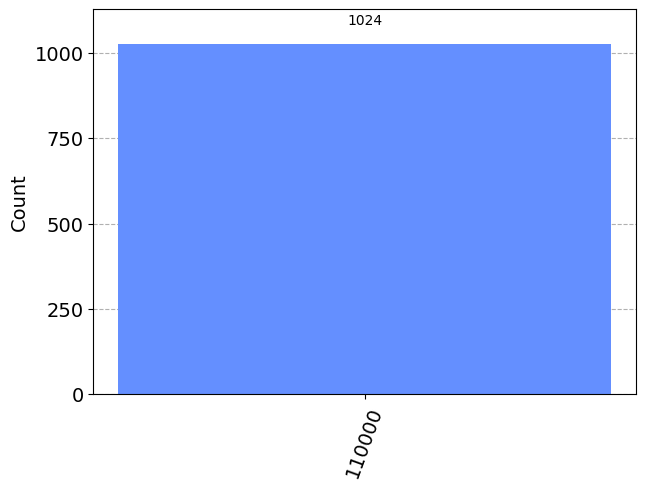

In [7]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ansatz.measure_all()

sim = AerSimulator()
job = sim.run(circuits=ansatz , shots=1024)
quantum_solution = job.result().get_counts()

key_with_max_value = max(quantum_solution, key=quantum_solution.get)

print("Gurobi Optimal Solution:", solution)
print("VQE Solution:", key_with_max_value)
plot_histogram(quantum_solution)